In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

print("Done!")

Done!


In [5]:
ticker = 'TSLA'
data = yf.download(ticker, start="2013-05-25", end="2024-05-25")
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-05-28,6.770000,7.383333,6.686667,7.355333,7.355333,295378500
2013-05-29,7.570000,7.660000,6.600000,6.975333,6.975333,376492500
2013-05-30,6.830667,7.302667,6.746667,6.996667,6.996667,242005500
2013-05-31,7.084000,7.096000,6.515333,6.517333,6.517333,227580000
2013-06-03,6.508000,6.508000,5.883333,6.172667,6.172667,287094000


In [15]:
data = data[['Close']]
print(data)

                 Close
Date                  
2013-05-28    7.355333
2013-05-29    6.975333
2013-05-30    6.996667
2013-05-31    6.517333
2013-06-03    6.172667
...                ...
2024-05-20  174.949997
2024-05-21  186.600006
2024-05-22  180.110001
2024-05-23  173.740005
2024-05-24  179.240005

[2769 rows x 1 columns]


In [19]:
#Normalizing dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
print(len(data))

# Define function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences
SEQ_LENGTH = 60
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Save the date index for the test set
date_index_test = data.index[SEQ_LENGTH + split:]

2769


In [20]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
# Build the LSTM regressor
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=100, batch_size=32)
print("Done")

Epoch 1/100
68/68 [==============================] - 48s 197ms/step - loss: 0.0057
Epoch 2/100
68/68 [==============================] - 16s 241ms/step - loss: 0.0023
Epoch 3/100
68/68 [==============================] - 17s 246ms/step - loss: 0.0021
Epoch 4/100
68/68 [==============================] - 17s 255ms/step - loss: 0.0019
Epoch 5/100
68/68 [==============================] - 17s 243ms/step - loss: 0.0019
Epoch 6/100
68/68 [==============================] - 17s 248ms/step - loss: 0.0016
Epoch 7/100
68/68 [==============================] - 17s 250ms/step - loss: 0.0016
Epoch 8/100
68/68 [==============================] - 17s 246ms/step - loss: 0.0019
Epoch 9/100
68/68 [==============================] - 17s 247ms/step - loss: 0.0014
Epoch 10/100
68/68 [==============================] - 17s 255ms/step - loss: 0.0014
Epoch 11/100
68/68 [==============================] - 17s 250ms/step - loss: 0.0016
Epoch 12/100
68/68 [==============================] - 19s 284ms/step - loss: 0.0015
E

68/68 [==============================] - 40s 588ms/step - loss: 8.2854e-04
Epoch 96/100
68/68 [==============================] - 59s 874ms/step - loss: 6.0259e-04
Epoch 97/100
68/68 [==============================] - 38s 544ms/step - loss: 6.1900e-04
Epoch 98/100
68/68 [==============================] - 39s 572ms/step - loss: 6.3179e-04
Epoch 99/100
68/68 [==============================] - 25s 361ms/step - loss: 6.8144e-04
Epoch 100/100
68/68 [==============================] - 22s 320ms/step - loss: 6.4844e-04
Done


In [21]:
regressor.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [25]:
# Make predictions
predictions = regressor.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test_scaled, predictions)
print(f'Mean Squared Error: {mse}')

17/17 [==============================] - 92s 65ms/step
Mean Squared Error: 93.86385551549083


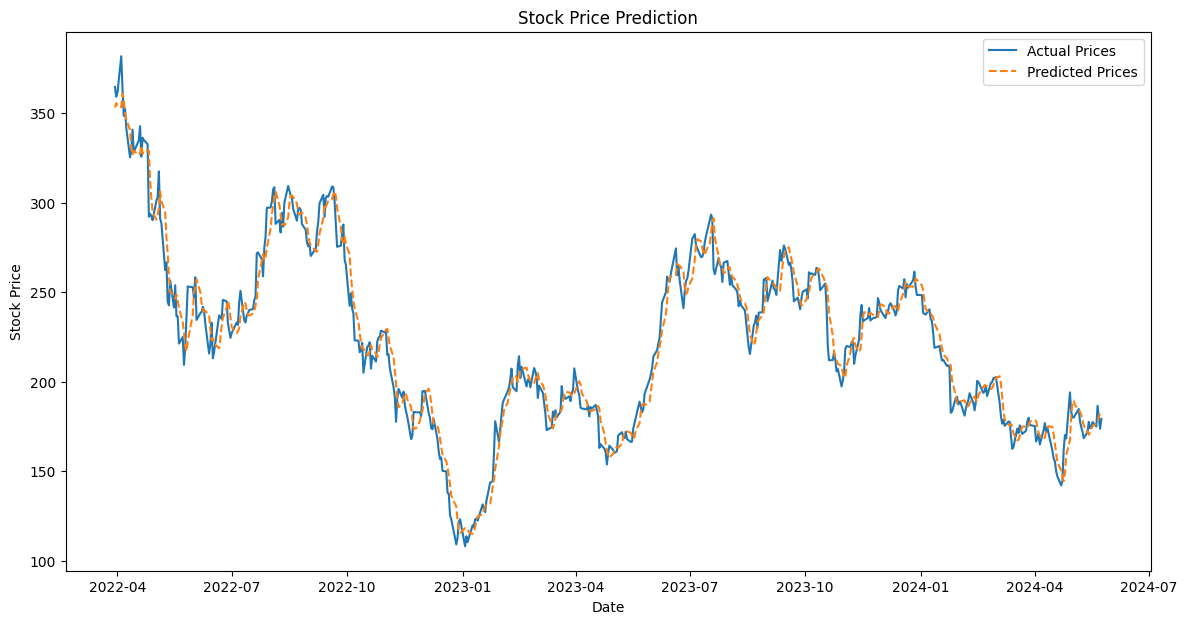

In [27]:
# Plot the actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(date_index_test, y_test_scaled, label='Actual Prices')
plt.plot(date_index_test, predictions, label='Predicted Prices', linestyle='dashed')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()